# Segmentación de Clientes FreshMart
Felipe Riquelme Burgos

In [1]:
# Librerias

!pip install scikit-fuzzy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import skfuzzy as fuzz
from sklearn.decomposition import PCA

Defaulting to user installation because normal site-packages is not writeable


## Importar datos

In [2]:
df = pd.read_excel('Retail_Invoices.xlsx')
df.head(5)

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB


In [4]:
df.drop_duplicates(inplace = True)

In [5]:
df.shape

(22190, 6)

En el estudio inicial, la información no presenta ni valores nulos ni duplicados

## Limpieza y preparación de datos

In [6]:
data_types = {}

for col in df.columns:
    type_counts = df[col].apply(type).value_counts()
    data_types[col] = type_counts.to_dict()

df_types = pd.DataFrame(data_types).fillna(0).astype(int)  # Convert NaN to 0 and ensure integer type
df_types

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
<class 'int'>,18536,0,22190,22190,0,22190
<class 'str'>,3654,0,0,0,0,0
<class 'pandas._libs.tslibs.timestamps.Timestamp'>,0,22190,0,0,0,0
<class 'float'>,0,0,0,0,22190,0


In [7]:
df['InvoiceNo']

0         536365
1         536366
2         536367
3         536368
4         536369
          ...   
22185    C581484
22186    C581490
22187    C581499
22188    C581568
22189    C581569
Name: InvoiceNo, Length: 22190, dtype: object

In [8]:
df[df['InvoiceNo'].astype(str).str.contains(r'[a-zA-Z]', na=False)]

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
18536,C536379,2010-12-01,14527,-1,-27.50,1
18537,C536383,2010-12-01,15311,-1,-4.65,1
18538,C536391,2010-12-01,17548,-132,-141.48,7
18539,C536506,2010-12-01,17897,-6,-25.50,1
18540,C536543,2010-12-01,17841,-3,-3.80,2
...,...,...,...,...,...,...
22185,C581484,2011-12-09,16446,-80995,-168469.60,1
22186,C581490,2011-12-09,14397,-23,-32.53,2
22187,C581499,2011-12-09,15498,-1,-224.69,1
22188,C581568,2011-12-09,15311,-5,-54.75,1


Durante la investigación del dataset se encontraron facturas con el prefijo C. Estos valores en cantidad y precio total presentan un número negativo. La anomalía puede tratarse por varias razones como devoluciones de productos o correciones en el stock o inventario. Sin embargo, debido a la inexactitud de la pertenencia de estos valores, se opta por eliminarlos aunque representen el 16% del dataset. Se debe agregar que es importante monitorear su comportamiento y estado a lo largo del tiempo ya que puede representar un motivo de análisis e investigación para corregir estos eventos ya sea una mala práctica de inventario o mala calidad del producto si se refiere a devoluciones.

In [9]:
contain_letters = (df[df['InvoiceNo'].astype(str).str.contains(r'[a-zA-Z]', na=False)]).index
df.drop(index = contain_letters, inplace = True)
df['InvoiceNo'] = df['InvoiceNo'].astype('float64')

In [10]:
df.describe()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
count,18536.000000,18536,18536.000000,18536.000000,18536.000000,18536.000000
mean,559527.999407,2011-07-01 03:51:21.053085952,15266.224158,279.547691,480.762187,21.467631
min,536365.000000,2010-12-01 00:00:00,12346.000000,1.000000,0.000000,1.000000
25%,548352.500000,2011-03-30 00:00:00,13773.500000,74.000000,157.930000,6.000000
50%,559818.500000,2011-07-12 00:00:00,15176.500000,155.000000,303.020000,15.000000
75%,570834.500000,2011-10-12 00:00:00,16779.000000,291.000000,471.660000,28.000000
max,581587.000000,2011-12-09 00:00:00,18287.000000,80995.000000,168469.600000,542.000000
std,13040.283892,NaN,1734.178524,976.796524,1678.029352,24.919243


In [11]:
df[df['price_total'] == 0]

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
2721,543599.0,2011-02-10,17560,16,0.0,1
11301,564651.0,2011-08-26,14646,576,0.0,4
12848,568384.0,2011-09-27,12748,1,0.0,1
17360,578841.0,2011-11-25,13256,12540,0.0,1


Siguiendo con el proceso de limpieza nos encontramos con registro cuyo precio total es 0 a pesar de que Quantity y StockCode presentan un comportamiento normal, es por ello que se procede a eliminar estos registros ya que puede haber sido debido a un error.

In [12]:
price_0 = (df[df['price_total'] == 0]).index
df.drop(index = price_0, inplace = True)

### Valores atípicos

In [13]:
columns_to_aty = ['Quantity','price_total','StockCode']

In [14]:
def histogram(data):
    for l in data[columns_to_aty]:
        plt.hist(data[l], bins = 100)
        plt.axvline(x = data[l].mean(), color = 'red', linestyle = 'dashed', linewidth = 2, label = 'Media')
        plt.axvline (x = data[l].median(), color = 'orange', linestyle = 'dashed', linewidth = 2, label = 'Mediana')
        plt.xlabel(l)
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()

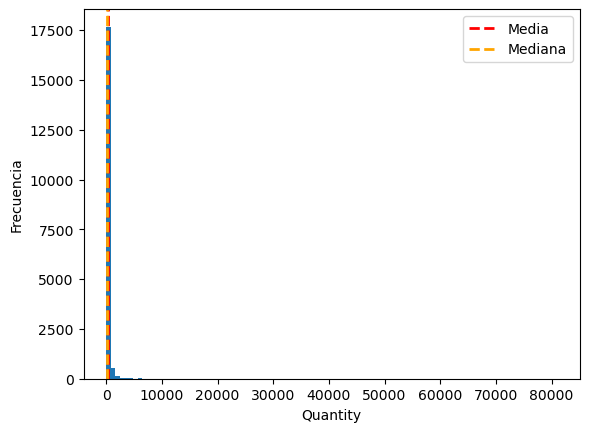

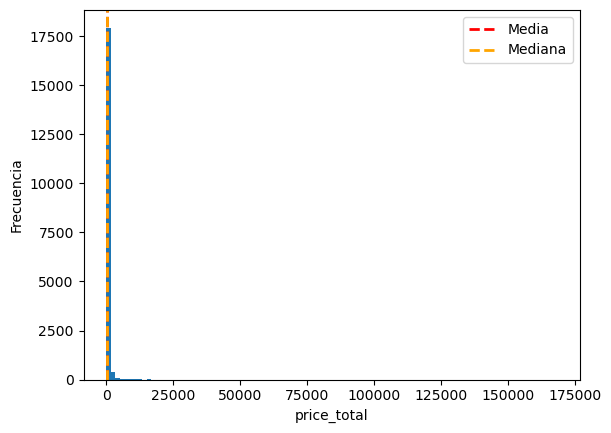

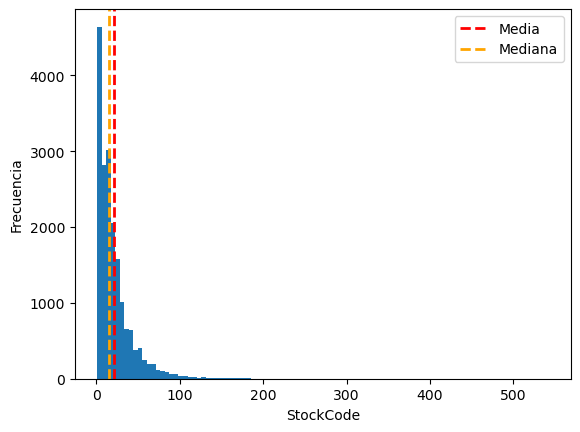

In [15]:
histogram(df)

En los gráficos de arriba se denota una alta presencia de valores atípicos que debido a su gran magnitud se utilizará el método de IQR para las columnas de Quantity, price_total y StockCode.

In [16]:
columns_to_aty = ['Quantity','price_total','StockCode']

# Cuenta de registros
cuenta_inic_reg = len(df)

for x in columns_to_aty:
    if x in df.columns:
    # Calcular límites IQR 
        q1_z = np.percentile(df[x], 25)
        q3_z = np.percentile(df[x], 75)
        iqr_z = q3_z - q1_z
        low_z = q1_z - 1.5 * iqr_z
        upp_z = q3_z + 1.5 * iqr_z

    # Filtrar dataset y contar registros removidos
    filtered_df = df[(df[x] >= low_z) & (df[x] <= upp_z)]
    reg_removed = len(df) - len(filtered_df)
    
    # Print el numero de registros removidos en cada columna
    print(f"En la Columna'{x}': {reg_removed} registros se removieron")
    
    # actualiza el DataFrame despues de cada iteración
    df = filtered_df


df.head(5)

En la Columna'Quantity': 1349 registros se removieron
En la Columna'price_total': 791 registros se removieron
En la Columna'StockCode': 942 registros se removieron


,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365.0,2010-12-01,17850,40,139.12,7
1,536366.0,2010-12-01,17850,12,22.20,2
2,536367.0,2010-12-01,13047,83,278.73,12
3,536368.0,2010-12-01,13047,15,70.05,4
4,536369.0,2010-12-01,13047,3,17.85,1


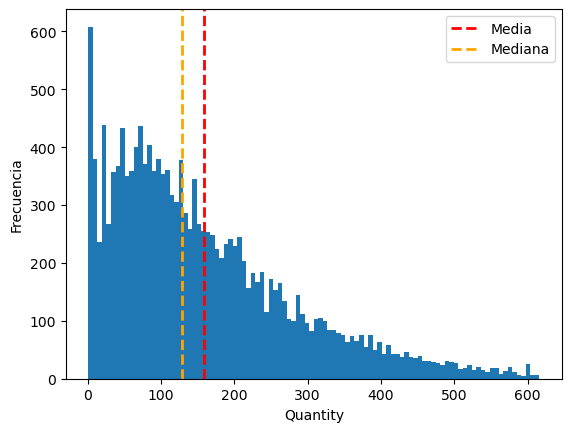

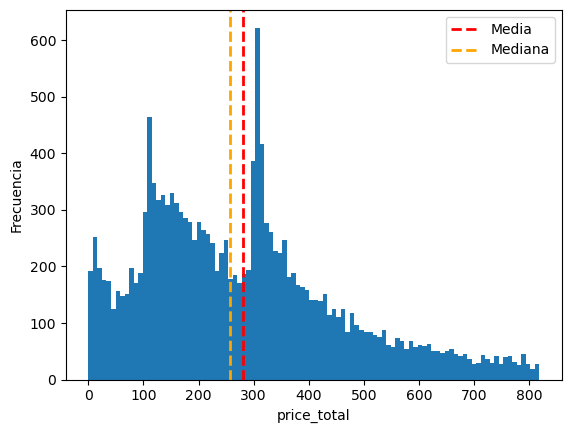

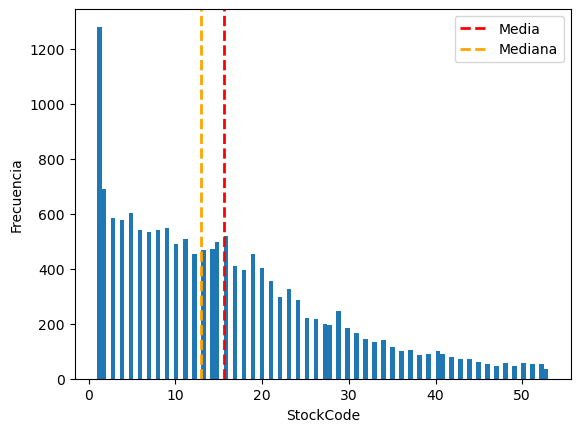

In [17]:
histogram(df)

In [18]:
df.reset_index(drop = True, inplace = True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15450 entries, 0 to 15449
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    15450 non-null  float64       
 1   InvoiceDate  15450 non-null  datetime64[ns]
 2   CustomerID   15450 non-null  int64         
 3   Quantity     15450 non-null  int64         
 4   price_total  15450 non-null  float64       
 5   StockCode    15450 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 724.3 KB


## Transformación de Variables (RFM)
Como se mencionó más arriba la distribución del dataset se encuentra a nivel de facturas y el objetivo del proyecto es analizar y segmentar los clientes del supermercado de FreshMart, es por ello que se realizará una transformación en la distribución del dataset por CustomerID agregando las variables última compra, frecuencia de compra (cantidad de veces que el cliente decidió comprar), promedio de artículos adquiridos, artículos totales comprados, promedio del monto de compra, monto total de compra y promedio de artículos distintos comprados. La tabla quedo de la siguiente manera:


In [20]:
df_seg = df.groupby('CustomerID').agg(
    last_buy = ('InvoiceDate','max'),
    frequency = ('InvoiceNo', 'count'),
    avg_quantity = ('Quantity', 'mean'),
    total_quantity = ('Quantity', 'sum'),
    avg_buy = ('price_total', 'mean'),
    total_buy = ('price_total', 'sum'),
    avg_distinc_product = ('StockCode', 'mean')
    )

df_seg

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product
CustomerID,,,,,,,
12347,2011-12-07,6,297.000000,1782,502.613333,3015.68,22.500000
12348,2011-09-25,3,362.333333,1087,301.480000,904.44,4.666667
12350,2011-02-02,1,197.000000,197,334.400000,334.40,17.000000
12352,2011-11-03,7,76.142857,533,237.962857,1665.74,11.714286
12353,2011-05-19,1,20.000000,20,89.000000,89.00,4.000000
...,...,...,...,...,...,...,...
18280,2011-03-07,1,45.000000,45,180.600000,180.60,10.000000
18281,2011-06-12,1,54.000000,54,80.820000,80.82,7.000000
18282,2011-12-02,2,51.500000,103,89.025000,178.05,6.000000


## Análisis

En lo que respecta a la distrubución de los datos finalmente tenemos información de aproximadamente 4000 clientes durante un año calendario del supermercado FreshMart. A pesar de haber eliminado valores atípicos usando el rango intercuartil, siguen presentándose valores fuera de la norma en las variables cuantitativas como se muestra en el gráfico de más abajo.


In [21]:
df_seg.describe()

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product
count,4038,4038.000000,4038.000000,4038.000000,4038.000000,4038.000000,4038.000000
mean,2011-09-01 07:43:35.750371584,3.826152,158.013333,606.947251,273.957736,1071.367093,16.492058
min,2010-12-01 00:00:00,1.000000,1.000000,1.000000,0.400000,0.400000,1.000000
25%,2011-06-30 00:00:00,1.000000,81.000000,135.000000,160.547500,262.230000,8.408696
50%,2011-10-14 00:00:00,2.000000,136.291667,298.500000,249.977500,541.495000,14.666667
75%,2011-11-21 00:00:00,4.000000,214.303571,679.000000,359.579300,1200.550000,22.750000
max,2011-12-09 00:00:00,186.000000,607.000000,28294.000000,817.890000,56276.880000,53.000000
std,NaN,6.287670,103.779513,1045.015896,146.611259,1867.124564,10.676890


In [22]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4038 entries, 12347 to 18287
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   last_buy             4038 non-null   datetime64[ns]
 1   frequency            4038 non-null   int64         
 2   avg_quantity         4038 non-null   float64       
 3   total_quantity       4038 non-null   int64         
 4   avg_buy              4038 non-null   float64       
 5   total_buy            4038 non-null   float64       
 6   avg_distinc_product  4038 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 252.4 KB


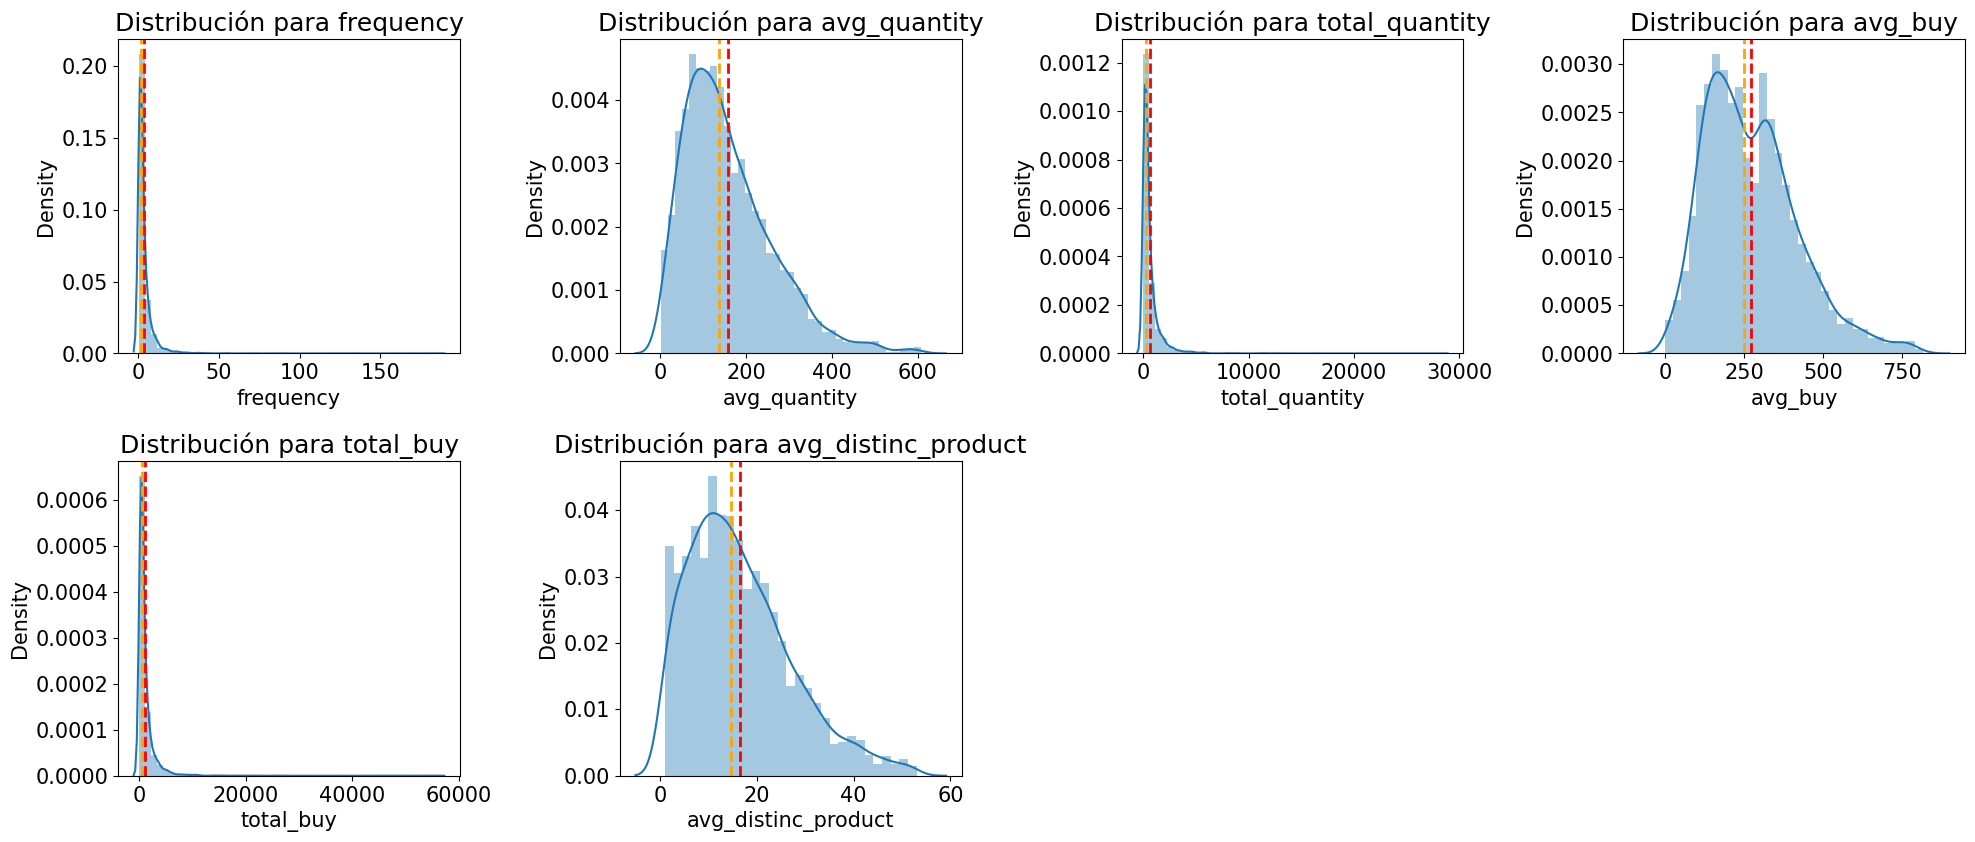

In [23]:
cols_graph = df_seg.drop(columns = ['last_buy'])
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(20, 25))  # Adjusted figsize
for n, i in enumerate(cols_graph.columns):
    plt.subplot(6, 4, n + 1)
    
    if df_seg[i].dtype == 'object':  # Check dtype correctly
        sns.countplot(y=df_seg[i], order=df_seg[i].value_counts().index[:7])  # Safer indexing
        plt.title(f'Frecuencias para {i}')

    else:
        sns.distplot(df_seg[i])
        plt.axvline(x = df_seg[i].mean(), color = 'red', linestyle = 'dashed', linewidth = 2, label = 'Media')
        plt.axvline (x = df_seg[i].median(), color = 'orange', linestyle = 'dashed', linewidth = 2, label = 'Mediana')
        plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

### Corrrelaciones

Respecto a las correlaciones destacan:
- La cantidad total de objetos con la compra total con 0.95
- La frecuencia de compra de los clientes con la compra total de un 0.86
- La cantidad total con la frecuencia de compra del cliente con un 0.85

<Axes: >

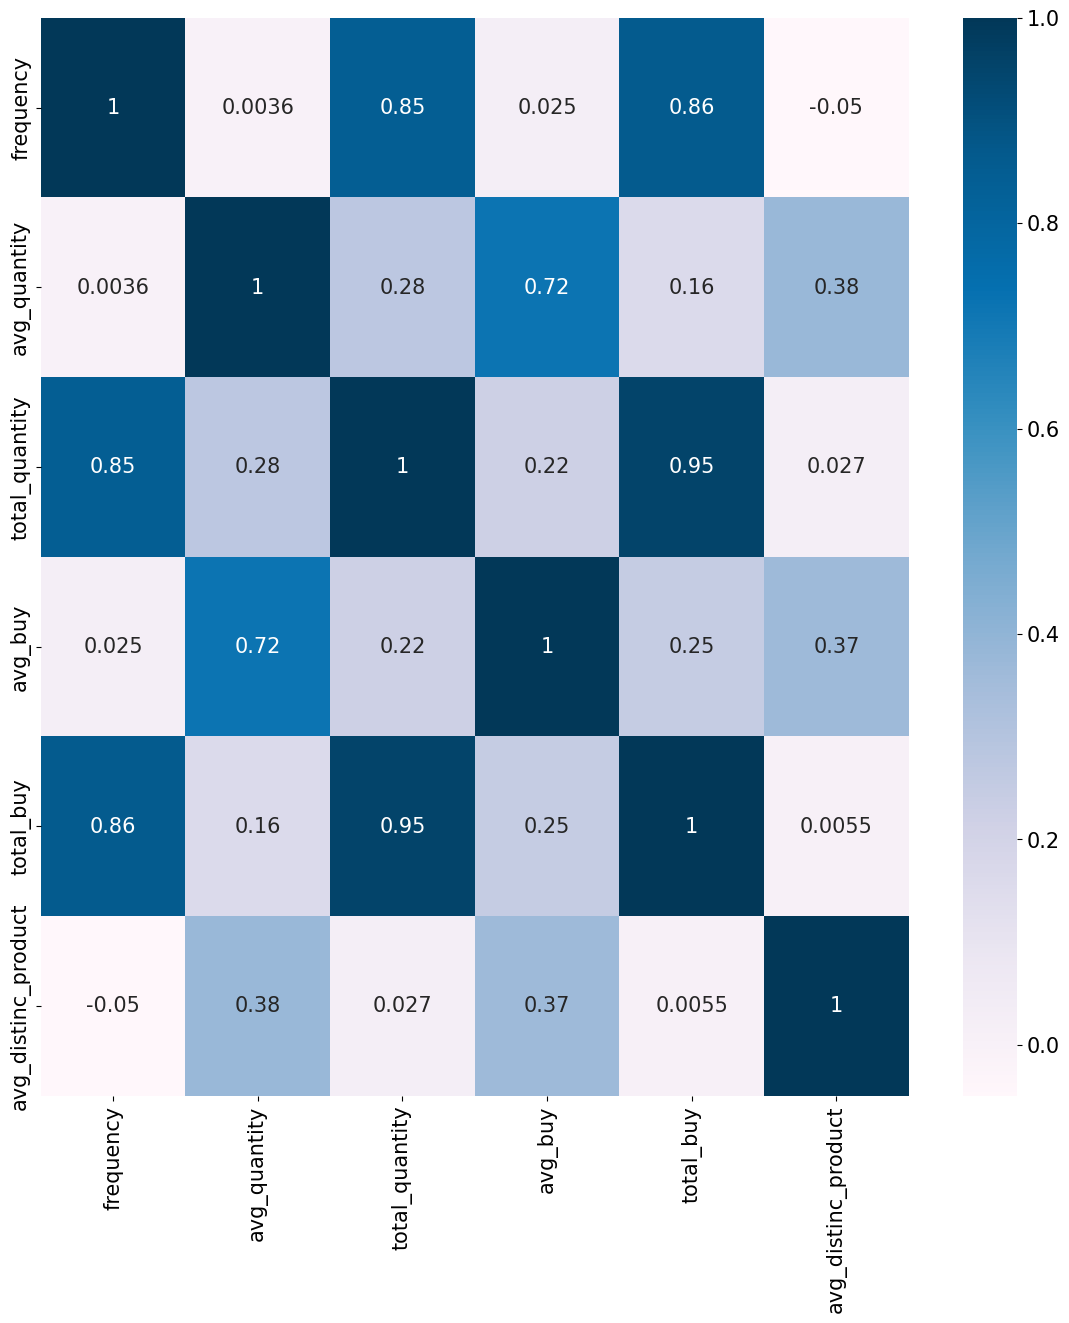

In [24]:
plt.figure(figsize= (14,14))
sns.heatmap(df_seg.corr(numeric_only = True), annot = True, cmap = plt.cm.PuBu)

Se elimina la columna last buy ya que es formato fecha

In [25]:
df_cl = df_seg.copy()
df_cl.drop(columns=['last_buy'], inplace= True)
df_cl

,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product
CustomerID,,,,,,
12347,6,297.000000,1782,502.613333,3015.68,22.500000
12348,3,362.333333,1087,301.480000,904.44,4.666667
12350,1,197.000000,197,334.400000,334.40,17.000000
12352,7,76.142857,533,237.962857,1665.74,11.714286
12353,1,20.000000,20,89.000000,89.00,4.000000
...,...,...,...,...,...,...
18280,1,45.000000,45,180.600000,180.60,10.000000
18281,1,54.000000,54,80.820000,80.82,7.000000
18282,2,51.500000,103,89.025000,178.05,6.000000


### Standard scaler

In [26]:
scaler = StandardScaler()
df_sca = scaler.fit_transform(df_cl)

In [27]:
df_sca

array([[ 0.34577478,  1.33941542,  1.12457455,  1.55979777,  1.04146972,
         0.56277491],
       [-0.1314086 ,  1.96903319,  0.45943053,  0.18774596, -0.08941437,
        -1.10770605],
       [-0.44953085,  0.37571477, -0.39233664,  0.41231314, -0.39475586,
         0.04757985],
       ...,
       [-0.29046972, -1.02646969, -0.48229856, -1.26153776, -0.47850462,
        -0.98281028],
       [ 0.98201928, -0.87035018,  0.06704341, -1.11964841,  0.01439981,
         1.58379785],
       [-0.29046972,  1.34905243, -0.01047698,  0.98246275, -0.12609563,
        -0.04609198]])

## Clustering y Evaluación


A continuación se procede a utilizar el algoritmo de K-means para visualizar cuales son las posibles segmentaciones que pueden tener los clientes.

### K-means

In [28]:
# Clusters K-means
sl, db, inertia = [], [], []
for num_clusters in range(2,11):
    km = KMeans(n_clusters= num_clusters, random_state= 12434).fit(df_sca)
    sl.append(silhouette_score(df_sca, km.labels_))
    db.append(davies_bouldin_score(df_sca, km.labels_))
    inertia.append(km.inertia_)

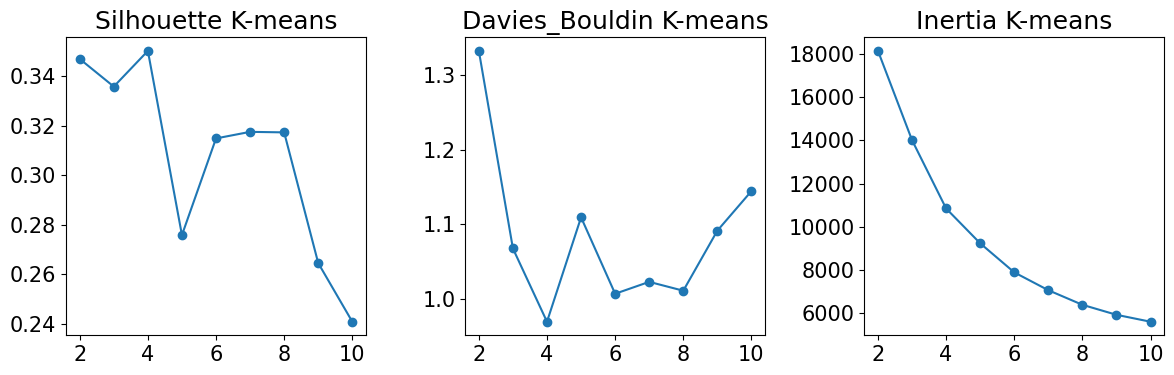

In [29]:
x_sitck = [2, 4, 6, 8, 10]

# Gráfico
plt.figure(figsize=(12,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(range(2,11), sl, '-o')
plt.title('Silhouette K-means')
plt.xticks(x_sitck) 

# Davies-Bouldin
plt.subplot(1,3,2)
plt.plot(range(2,11), db, '-o')
plt.title('Davies_Bouldin K-means')
plt.xticks(x_sitck) 

# Inertia
plt.subplot(1,3,3)
plt.plot(range(2,11), inertia, '-o')
plt.title('Inertia K-means')
plt.xticks(x_sitck) 

plt.tight_layout()

En el gráfico de arriba se logra visualizar en silhouette que el punto más alto es 4 clusters y davies_bouldin 4 clusters es el punto más bajo. Es por ello que se instanciará el modelo con 4 clusters y se utilizará el algoritmo de PCA para reducir la dimensionalidad a 2 con fines de poder visualizar los resultados.

In [30]:
# 4 clusters
km_4_dim = KMeans(n_clusters= 4, random_state= 12434).fit(df_sca)

#PCA
x_2_dim = pd.DataFrame(PCA(n_components = 2).fit_transform(df_sca))
x_2_dim.columns = ['col1', 'col2'] 

# agregar clusters al dataframe
x_2_dim['cluster'] = km_4_dim.labels_
x_2_dim

,col1,col2,cluster
0,2.145300,1.466388,1
1,0.560185,0.690247,1
2,-0.465335,0.721883,1
3,0.096582,-0.995945,0
4,-1.574444,-1.718158,0
...,...,...,...
4033,-1.267609,-0.976185,0
4034,-1.468056,-1.432237,0
4035,-1.333937,-1.522337,0
4036,0.191593,-0.669697,0


Text(0.5, 1.0, 'Clustering K-means')

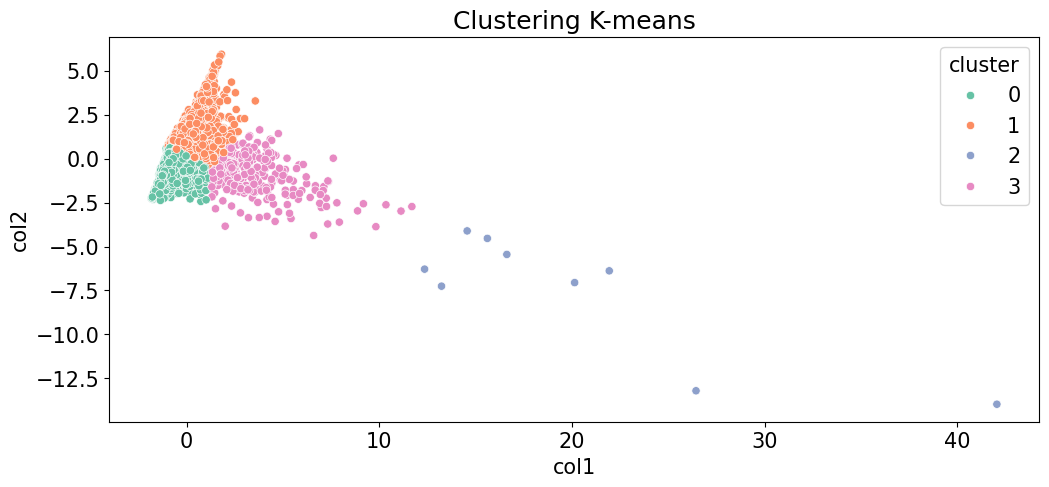

In [31]:
# Gráfico Clusters K-means
plt.figure(figsize =(12,5))
sns.scatterplot(data = x_2_dim, x = 'col1', y = 'col2', hue = 'cluster',palette = 'Set2')
plt.title('Clustering K-means')

Ahora se utilizará el modelo Fuzzy C-Means para contrastar con K-means

### Fuzzy C-means

In [32]:
# M_value
m_values = np.arange(1.1, 3.1, 0.1)


silhouette_scores = []
davies_bouldin_scores = []

for m in m_values:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_sca.T, 4, m, error=0.005, maxiter=1000) #explicar este código
    labels = np.argmax(u, axis=0)

    # Silohouette
    silhouette_scores.append(silhouette_score(df_sca, labels))

    # Dunn
    dunn_index = davies_bouldin_score(df_sca, labels)
    davies_bouldin_scores.append(dunn_index)

# Opt M
optimal_index = np.argmax(silhouette_scores)
optimal_m = m_values[optimal_index]

In [33]:
optimal_m

1.4000000000000004

In [34]:
# CLusters Fuzzy C-means
cluster_range = range(2, 11)
silhouette_scores_c = []
db_scores_c = []
jm_values = []

for c in cluster_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        df_sca.T, c, m=optimal_m, error=0.005, maxiter=1000, seed=42
    )
    labels = np.argmax(u, axis=0)
    
    silhouette_scores_c.append(silhouette_score(df_sca, labels))
    db_scores_c.append(davies_bouldin_score(df_sca, labels))
    jm_values.append(jm[-1])

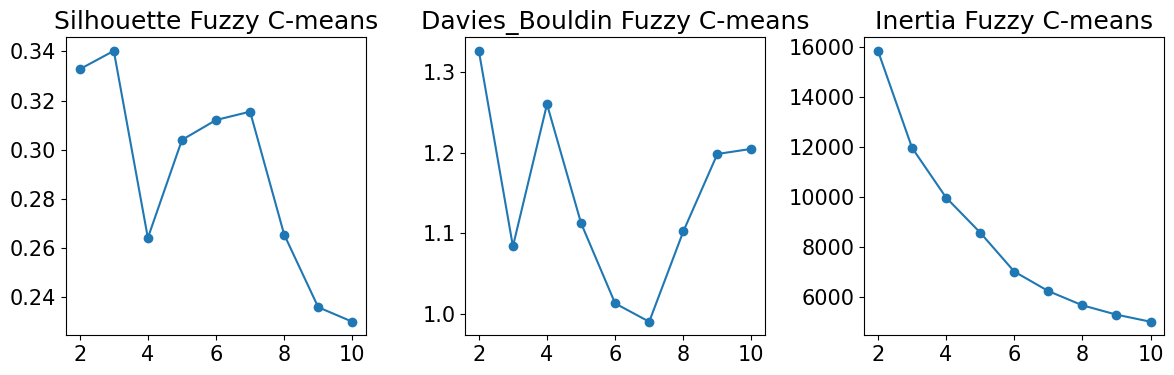

In [35]:
x_sitck = [2, 4, 6, 8, 10]

# Gráfico
plt.figure(figsize=(12,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(range(2,11), silhouette_scores_c, '-o')
plt.title('Silhouette Fuzzy C-means')
plt.xticks(x_sitck) 

# Davies-Bouldin
plt.subplot(1,3,2)
plt.plot(range(2,11), db_scores_c, '-o')
plt.title('Davies_Bouldin Fuzzy C-means')
plt.xticks(x_sitck) 

# Inertia
plt.subplot(1,3,3)
plt.plot(range(2,11), jm_values, '-o')
plt.title('Inertia Fuzzy C-means')
plt.xticks(x_sitck) 

plt.tight_layout()

Debido a la cercanía del valor óptimo de m al valor 1 y los gráficos de Silhouette e Inertia se procede a utilizar la separación con 3 clusters para Fuzzy C-means

In [36]:
# Clusterización con el valor óptimo de m 
optimal_cntr, optimal_u, optimal_u0, optimal_d, optimal_jm, optimal_p, optimal_fpc = fuzz.cluster.cmeans(df_sca.T, 3, optimal_m, error=0.005, maxiter=1000)
optimal_labels = np.argmax(optimal_u, axis=0)

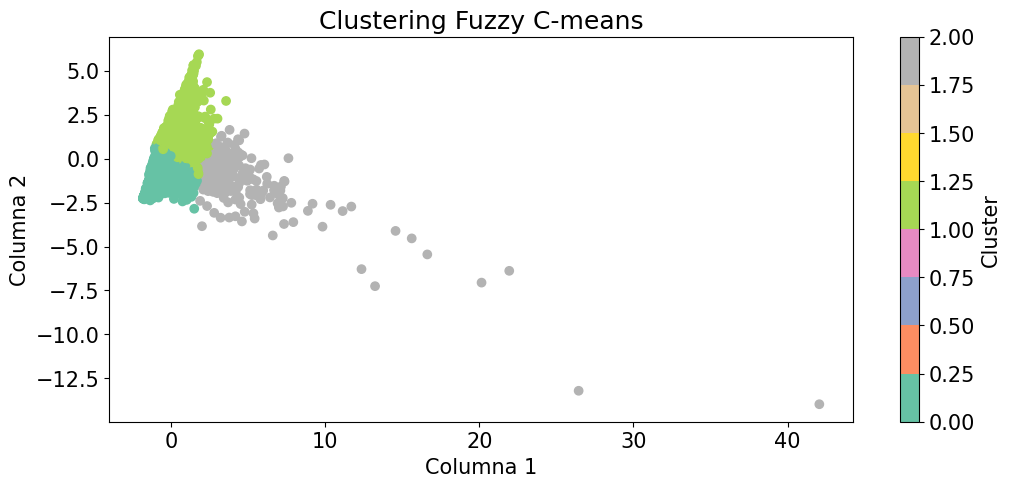

In [37]:
pca = PCA(n_components=2)
seg_scaled_pca = pca.fit_transform(df_sca)

# Gráfico Clusters Fuzzy C-means
plt.figure(figsize =(12,5))
plt.scatter(seg_scaled_pca[:, 0], seg_scaled_pca[:, 1], c=optimal_labels, cmap='Set2')
plt.title('Clustering Fuzzy C-means')
plt.xlabel('Columna 1')
plt.ylabel('Columna 2')
plt.colorbar(label='Cluster')
plt.show()

### Evaluación de los algoritmos

#### K-means

In [38]:
silhouette_kmeans = silhouette_score(df_sca, km_4_dim.labels_)
davies_bouldin_kmeans = davies_bouldin_score(df_sca, km_4_dim.labels_)

print(f"K-Means Silhouette Score: {silhouette_kmeans}")
print(f"K-Means Davies Bouldin Score: {davies_bouldin_kmeans}")

K-Means Silhouette Score: 0.35010922125461674
K-Means Davies Bouldin Score: 0.9688725504594399


#### Fuzzy C-means

In [39]:
silhouette_fuzzy = silhouette_score(df_sca, optimal_labels)
davies_bouldin_fuzzy = davies_bouldin_score(df_sca, optimal_labels)

print(f"Fuzzy C-Means Silhouette Score: {silhouette_fuzzy}")
print(f"Fuzzy C-Means Davies Bouldin Score: {davies_bouldin_fuzzy}")

Fuzzy C-Means Silhouette Score: 0.34022744188059084
Fuzzy C-Means Davies Bouldin Score: 1.0839801221997591


### Segmentos y conclusiones

Observando los valores de Silhouette y Davies-Bouldin se concluye que K-means tiene un mejor resultado para los clusters del dataframe que Fuzzy C-means, sin embargo, estos valores no son perfectos y hay oportunidad de mejora. Si bien tenemos 4000 registros, se recomienda recopilar más información respecto a nuevos y actuales clientes por al menos otro año, además considerar agregar mas atributos como la categoría de productos que se adquieren.

A continuación habiendo elegido K-means como mejor modelo se procede a realizar la segmentación de estos clientes acorde a sus características.

In [40]:
df_seg['Cluster_K_means'] = km_4_dim.labels_

##### Clientes Ocasionales
Con una frecuencia de compra baja comparada al resto de segmentos al igual que el total de compra y cantidad de productos, estos clientes se presentan como un tipo de compradores ocasionales que visitan la zona o se encuentran de paso hacia un destino en particular. Este número de clientes es el más alto lo que puede indicar que la geolocalización del supermercado es cercana a algún lugar turístico o cercano a un lugar donde se suele reunir una gran cantidad de gente por periodos estacionales durante la temporada. Todo esto considerando que la separación entre clusters es muy baja. Considerando la información anterior, sería de gran utlilidad para un futuro análisis saber si el supermercado es cercano a algún lugar turístico o frecuenta gran cantidad de personas de ser así, en fechas donde hay una gran afluencia de personas, generar eventos de activación de marca presenciales y a través de las redes sociales. Aunque se debe considerar que es peligroso que la mayor cantidad de clientes sea de este tipo.

In [41]:
cl_ocasionales_desc = df_seg.query('Cluster_K_means == 0').describe()[:7]
cl_ocasionales = df_seg.query('Cluster_K_means == 0')
cl_ocasionales_desc

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,2247,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.0
mean,2011-08-18 14:50:47.263017472,2.737873,93.985044,265.478416,185.088238,524.722404,11.897534,0.0
min,2010-12-01 00:00:00,1.000000,1.000000,1.000000,0.400000,0.400000,1.000000,0.0
25%,2011-06-03 00:00:00,1.000000,55.583333,84.000000,123.687500,169.185000,6.000000,0.0
50%,2011-10-04 00:00:00,2.000000,88.500000,165.000000,174.025000,330.030000,10.333333,0.0
75%,2011-11-17 00:00:00,4.000000,126.464286,348.500000,237.200000,694.420000,15.291667,0.0
max,2011-12-09 00:00:00,17.000000,331.000000,1776.000000,550.940000,3110.960000,51.000000,0.0


In [42]:
cl_ocasionales[cl_ocasionales['total_buy'] >600].describe()

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,668,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.0
mean,2011-10-14 12:58:12.215568896,5.302395,112.323965,568.332335,233.995336,1162.008085,12.720090,0.0
min,2011-01-07 00:00:00,2.000000,5.666667,17.000000,86.800000,600.070000,1.000000,0.0
25%,2011-09-27 00:00:00,3.000000,82.729167,350.000000,179.368532,754.257500,8.312500,0.0
50%,2011-11-10 00:00:00,5.000000,111.500000,500.000000,226.840417,987.480000,12.000000,0.0
75%,2011-11-28 00:00:00,7.000000,138.500000,753.500000,279.706375,1391.692500,15.666667,0.0
max,2011-12-09 00:00:00,17.000000,282.000000,1776.000000,489.280000,3110.960000,36.875000,0.0
std,NaN,2.541681,41.556530,294.600709,71.171913,522.184830,6.931351,0.0


##### Buscadores de ofertas
Con una frecuencia de compra similar a los clientes ocasionales pero un significativo aumento en la cantidad de productos, compra total y la compra de productos diferentes mas alta del segmento , estos clientes se pueden clasificar como buscadores de ofertas. Estos clientes aparecen en cambios de temporada, renovación de stock de productos electrodomésticos (si es que el supermercado ofrece), ropa, entre otros. Como bien lo dice el nombre estos clientes buscan ofertas en periodos específicos del año como por ejemplo, en Chile exista una migración por parte de Argentinos debido a que los precios a productos electrodomésticos son más baratos en nuestro país. La estrategia que se pude tomar con este tipo de clientes es ofrecer descuentos en volumenes de productos y promociones por tiempo limitado si es que el negocio e identidad del supermercado hace fit con esta estrategia.

In [43]:
cl_ofertas_desc = df_seg.query('Cluster_K_means == 1').describe()[:7]
cl_ofertas = df_seg.query('Cluster_K_means == 1')
cl_ofertas_desc

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,1482,1482.000000,1482.000000,1482.000000,1482.000000,1482.000000,1482.000000,1482.0
mean,2011-09-05 01:35:13.360324096,2.609987,248.485439,618.760459,396.962601,995.484893,23.862359,1.0
min,2010-12-01 00:00:00,1.000000,58.000000,64.000000,97.970000,97.970000,1.000000,1.0
25%,2011-07-20 06:00:00,1.000000,178.625000,266.250000,310.922250,419.125000,17.400000,1.0
50%,2011-10-10 00:00:00,2.000000,231.875000,475.000000,375.278333,743.020000,22.166667,1.0
75%,2011-11-16 00:00:00,4.000000,302.000000,854.000000,469.671250,1395.302500,29.950000,1.0
max,2011-12-09 00:00:00,11.000000,607.000000,2856.000000,817.890000,3781.740000,53.000000,1.0


In [44]:
cl_ofertas[cl_ofertas['total_buy'] > 1300].describe()

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,418,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0
mean,2011-10-20 16:18:22.392344576,5.016746,242.637169,1167.746411,417.302028,1977.028636,21.126794,1.0
min,2011-02-23 00:00:00,2.000000,58.000000,174.000000,184.866667,1303.910000,1.000000,1.0
25%,2011-10-05 00:00:00,4.000000,185.687500,864.250000,341.638000,1536.692500,16.000000,1.0
50%,2011-11-09 12:00:00,5.000000,228.325000,1111.000000,401.531071,1815.765000,20.750000,1.0
75%,2011-11-28 00:00:00,6.000000,293.907143,1410.750000,476.576625,2298.922500,25.900000,1.0
max,2011-12-09 00:00:00,11.000000,524.666667,2856.000000,777.900000,3781.740000,47.000000,1.0
std,NaN,1.701236,79.303820,429.018095,110.919530,563.237892,7.902058,0.0


##### Clientes Fieles
En el cluster número 3 tenemos clientes que tienen el segundo monto total más alto, presentan una media de 15 visitas al supermercado al año y un gasto promedio de 330. Se clasificarían como los compradores regulares o fieles que abastecen todas sus necesidades con aproximadamente una visita por mes al supermercado. A nivel general no solo en este segmento lo que se puede hacer es crear un programa de fidelización que permita ofrecer a todos los clientes acorde a sus comportamientos de compra las mejores ofertas.

In [45]:
cl_fieles_desc = df_seg.query('Cluster_K_means == 3').describe()[:7]
cl_fieles =  df_seg.query('Cluster_K_means == 3')
cl_fieles_desc

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,300,300.000000,300.000000,300.000000,300.000000,300.0000,300.000000,300.0
mean,2011-11-21 16:04:48,15.503333,189.952217,2718.043333,330.662364,4861.3934,14.617251,3.0
min,2010-12-02 00:00:00,7.000000,14.358974,560.000000,33.242051,1296.4400,1.000000,3.0
25%,2011-11-17 00:00:00,10.000000,136.305556,1837.500000,262.831625,3385.1250,9.285539,3.0
50%,2011-11-30 00:00:00,13.000000,187.003788,2406.500000,330.218000,4112.8050,14.323864,3.0
75%,2011-12-06 00:00:00,18.000000,240.737879,3334.750000,390.134295,5548.4950,19.779762,3.0
max,2011-12-09 00:00:00,55.000000,403.250000,8886.000000,633.480000,16036.7900,39.964286,3.0


In [46]:
cl_fieles[cl_fieles['total_buy'] > 5500].describe()

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,76,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.0
mean,2011-11-27 23:03:09.473684224,23.565789,190.345234,4122.131579,365.286616,8032.486579,14.115048,3.0
min,2011-09-02 00:00:00,10.000000,37.981818,1257.000000,154.188378,5548.080000,1.130435,3.0
25%,2011-11-25 00:00:00,17.750000,146.506250,3042.000000,309.900261,6166.637500,7.976460,3.0
50%,2011-12-02 00:00:00,23.000000,184.460000,3946.500000,366.374047,7316.160000,14.455000,3.0
75%,2011-12-07 00:00:00,28.000000,246.677083,4906.750000,431.738636,9074.327500,17.747789,3.0
max,2011-12-09 00:00:00,55.000000,336.200000,8886.000000,585.040000,16036.790000,39.964286,3.0
std,NaN,8.824716,72.051352,1475.198204,100.353871,2439.118826,7.835426,0.0


##### Outliers
Encontramos en el cluster numero 2, 9 elementos que sobresalen de toda norma y medio, se van totalmente al extremo en cantidades compradas y totales lo que recibiran el nombre de Outliers, sera interesante investigar mas sobre estos 9 clientes ya que puede deberse a que por su comportamiento de compra se pueda tratar de negocios minoristas que se mueven a un supermercado central (teoría de geolocalización) para comprar y vender en zonas más alejadas a lugares con una gran afluencia de clientes. Si la filosofía e identidad del supermercado condice, se puede tomar una perspectiva colaborativa y ofrecer el despacho de estos productos a los revendedores o comerciantes si es que se desea fidelizar y ofrecer un servicio completo pudiendo abarcar mas zonas y atraer posibles nuevos comerciantes.

In [47]:
df_seg.query('Cluster_K_means == 2').describe()[:7]

,last_buy,frequency,avg_quantity,total_quantity,avg_buy,total_buy,avg_distinc_product,Cluster_K_means
count,9,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,2011-12-03 10:40:00,86.555556,181.373197,13545.222222,316.753747,23711.383333,12.442246,2.0
min,2011-11-01 00:00:00,42.000000,65.033333,5853.000000,107.158280,11004.810000,3.088889,2.0
25%,2011-12-06 00:00:00,55.000000,102.011765,11197.000000,129.468353,18700.450000,4.166667,2.0
50%,2011-12-08 00:00:00,73.000000,209.585185,12431.000000,383.692182,21103.070000,10.972603,2.0
75%,2011-12-08 00:00:00,90.000000,244.058824,13957.000000,416.865778,25715.080000,18.844444,2.0
max,2011-12-09 00:00:00,186.000000,273.476190,28294.000000,487.334889,56276.880000,27.988889,2.0
